The audio dataset that is used comes from:
[CMU ARCTIC](http://www.festvox.org/cmu_arctic/)

(0.0, 4.0)

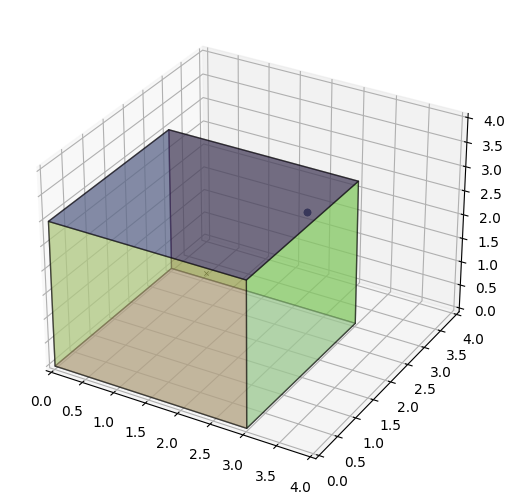

In [2]:
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import math

# specify signal source
fs, signal = wavfile.read("..\\data\\original\\arctic_a0010.wav")

# generate 2D room
corners = np.array([[0,0], [0,3.], [3.,3.], [3.,0]]).T  # [x,y]
room = pra.Room.from_corners(corners, fs=fs, max_order=3)
room.extrude(3.)

# add sound source to room
room.add_source([2.5,2.5,2.5], signal=signal)

# add microphone
mic_loc = [1.5, 1.5, 1.5]
room.add_microphone(mic_loc)

fig, ax = room.plot()
ax.set_xlim([0, 4])
ax.set_ylim([0, 4])
ax.set_zlim([0, 4])

Similarly to the image-source method, ray tracing assumes that sound energy travels around a scene in “rays”. The rays start at the sound source, and are all emitted in uniformly random directions at the same time, travelling at the speed of sound.

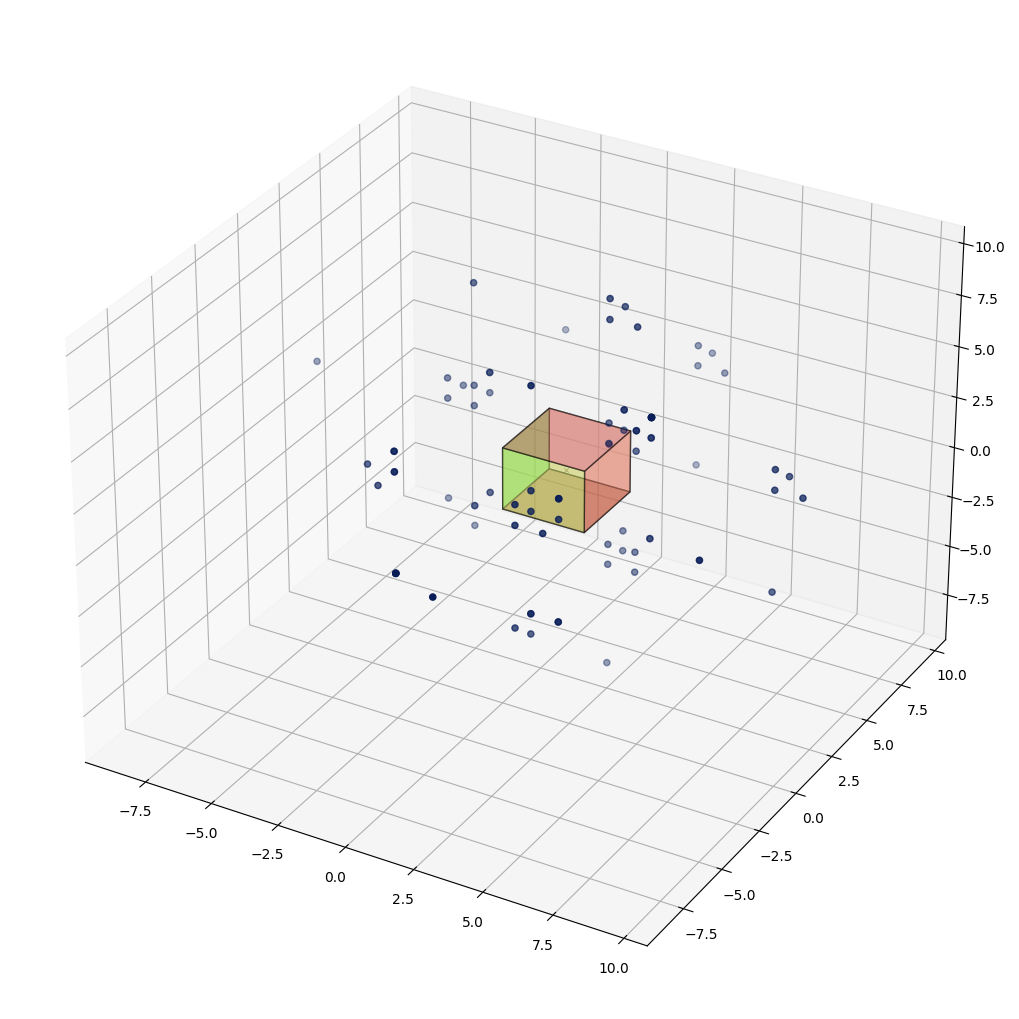

In [3]:
# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# compute image sources
room.image_source_model()

# visualize 3D polyhedron room and image sources
fig, ax = room.plot()
fig.set_size_inches(20, 10)

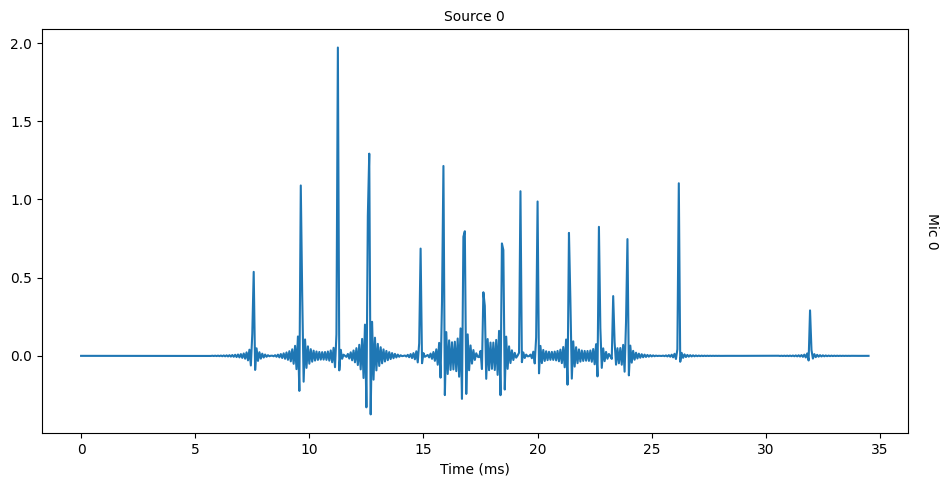

In [4]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(10, 5)

In order to calculate the signal-to-noise ratio (SNR) in dB:

SNR = 10log10(K/sigma^2) where K-number sources and sigma is the variance of the noise

In Computational Audiotory Scene Analysis the SNR should be kept above 10dB (page) in order for the sound to be somehow intelligebla.

In [5]:
snr = 10*math.log10(room.n_mics/0.001)
print(snr)

room.simulate(reference_mic=0, snr=snr)

30.0


The RT60 is 14 ms


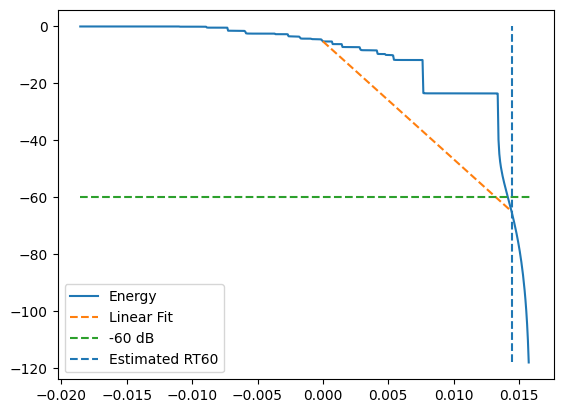

In [6]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

In [7]:
# original signal
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

Original WAV:


In [8]:
print("Simulated propagation to first mic:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

Simulated propagation to first mic:


How to use this to get the DOA.
Pyroomacoustics has some standard mathematical models that can estimate this (SRP-PHAT, MUSIC, CSSM, WAVES, TOPS, and FRIDA)

In [9]:
# Location of source
azimuth = np.array([180.]) / 180. * np.pi # convert degree to radians
distance = 1.5  # meters

c = 343.                                                    # speed of sound
fs = 16000                                                  # sampling frequency
nfft = 256                                                  # Fast Fourier Transform size
freq_range = [300, 3500]
snr_db = 10.                                                 # signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2    # noise variance

# Create an anechoic room
room_dim = np.r_[5.,5.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=3, ray_tracing=True, sigma2_awgn=sigma2)
aroom.extrude(2.)
aroom.set_ray_tracing(receiver_radius=0.25, n_rays=2500, energy_thres=1e-8)

# add microphone
microphones = np.c_[[2.55, 2.55, 1.],[ 2.45, 2.45, 1.]]
#echo = pra.circular_2D_array(center=room_dim/2, M=6, phi0=0, radius=37.5e-3)
#echo = np.concatenate((echo, np.array(room_dim/2, ndmin=2).T), axis=1)

# add sources
rng = np.random.RandomState(23)
duration_samples = int(fs)
source_location = room_dim / 2 + distance * np.r_[np.cos(azimuth), np.sin(azimuth)]
source_signal = rng.randn(duration_samples)
aroom.add_source(np.append(source_location, 1.), signal=source_signal)

aroom.add_microphone_array(microphones)
#aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))

# Run the simulation
aroom.simulate()

# Check the room impulse response

#t60 = pra.experimental.measure_rt60(aroom.rir[0][0], fs=aroom.fs, plot=True)
#print(f"The RT60 is {t60 * 1000:.0f} ms")

(0.0, 2.0)

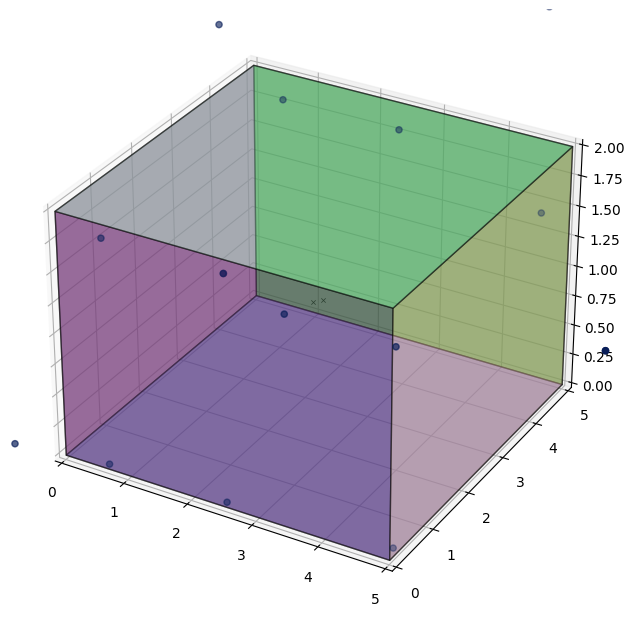

In [10]:
fig, ax = aroom.plot()
fig.set_size_inches(6, 6)
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
ax.set_zlim([0, 2.])

In [11]:
azimuth

array([3.14159265])

In [12]:
IPython.display.Audio(source_signal, rate=fs)

In [13]:
# The DOA algorithms require an short-time Fourier transform input, 
# which is computed for overlapping frames for the 1 second duration signal.

# Size should be M x F x S, where M should correspond to the
# number of microphones, F to nfft/2+1, and S to the number of snapshots
# (user-defined). It is recommended to have S >> M.
X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

In [14]:
algo_names = ['MUSIC', 'TOPS']
spatial_resp = dict()

# loop through algos
for algo_name in algo_names:
    # Construct the new DOA object
    doa = pra.doa.algorithms[algo_name](microphones, fs, nfft, c=c, num_src=1)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_range=freq_range)
    
    # store spatial response
    spatial_resp[algo_name] = doa.grid.values
        
    # normalize   
    min_val = spatial_resp[algo_name].min()
    max_val = spatial_resp[algo_name].max()
    spatial_resp[algo_name] = (spatial_resp[algo_name] - min_val) / (max_val - min_val)

(0.0, 11.55)

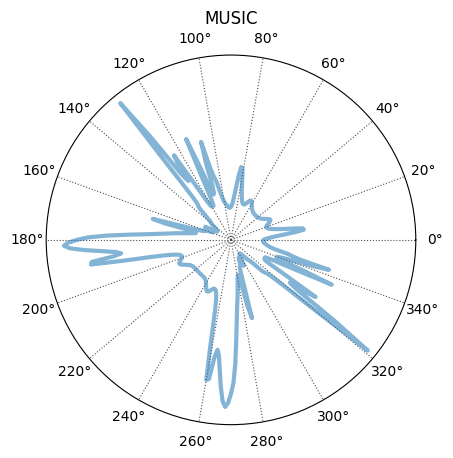

In [15]:
spatial_resp = None
X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

# Construct the new DOA object and perform localization on the frames in X
doa = pra.doa.algorithms['MUSIC'](microphones, fs, nfft, c=c, num_src=1)
doa.locate_sources(X, freq_range=freq_range)
spatial_resp = doa.grid.values  
min_val = spatial_resp.min()
max_val = spatial_resp.max()
spatial_resp = (spatial_resp - min_val) / (max_val - min_val)

# Vizualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

phi_plt = doa.grid.azimuth
c_phi_plt = np.r_[phi_plt, phi_plt[0]]
c_dirty_img = np.r_[spatial_resp, spatial_resp[0]]

ax.plot(c_phi_plt, 1 + 10 * c_dirty_img, linewidth=3, alpha=0.55, linestyle='-', label="spectrum")
plt.title('MUSIC')
ax.set_xticks(np.linspace(0, 2 * np.pi, num=18, endpoint=False))
ax.set_yticks(np.linspace(0, 0, 0))
ax.xaxis.grid(visible=True, color=[0.3, 0.3, 0.3], linestyle=':')
ax.set_ylim([0, 1.05*(10 + 1)])